<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
# Import libraries for data wrangling, preprocessing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# Importing libraries for building the neural network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

Read in file

In [3]:
from google.colab import files
uploaded = files.upload()
dataset = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full.csv


In [4]:
sns.set_style('dark')
import matplotlib as mpl
mpl.style.use(['https://gist.githubusercontent.com/BrendanMartin/01e71bb9550774e2ccff3af7574c0020/raw/6fa9681c7d0232d34c9271de9be150e584e606fe/lds_default.mplstyle'])
mpl.rcParams.update({"figure.figsize": (8,6), "axes.titlepad": 22.0})

Data Exploration

Target variables  :  0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: target, Length: 41188, dtype: object
Unique values of the target variable ['no' 'yes']
Counts of the target variable : [36548  4640]


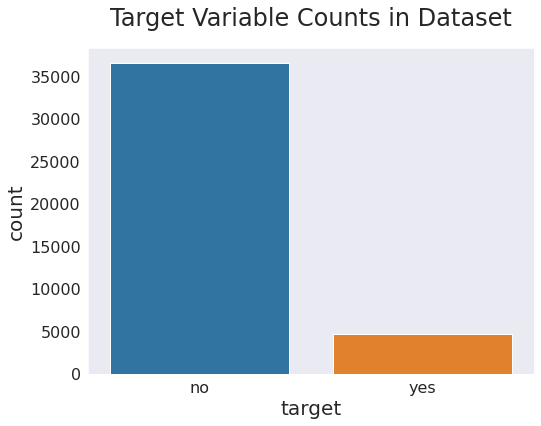

In [5]:
dataset.rename(columns = {'y':'target'}, inplace = True)

print('Target variables  : ', dataset['target'])
(unique, counts) = np.unique(dataset['target'], return_counts=True)

print('Unique values of the target variable', unique)
print('Counts of the target variable :', counts)

sns.countplot(data = dataset,x = 'target')
plt.title('Target Variable Counts in Dataset')
plt.show()

Turn categories to numerical

In [6]:
dataset['target'] = pd.factorize(dataset['target'])[0] + 1
dataset['job'] = pd.factorize(dataset['job'])[0] + 1
dataset['marital'] = pd.factorize(dataset['marital'])[0] + 1
dataset['education'] = pd.factorize(dataset['education'])[0] + 1
dataset['default'] = pd.factorize(dataset['default'])[0] + 1
dataset['housing'] = pd.factorize(dataset['housing'])[0] + 1
dataset['default'] = pd.factorize(dataset['default'])[0] + 1
dataset['loan'] = pd.factorize(dataset['loan'])[0] + 1
dataset['contact'] = pd.factorize(dataset['contact'])[0] + 1
dataset['month'] = pd.factorize(dataset['month'])[0] + 1
dataset['day_of_week'] = pd.factorize(dataset['day_of_week'])[0] + 1
dataset['poutcome'] = pd.factorize(dataset['contact'])[0] + 1

# Should remove - duration as only for benchmark
dataset = dataset.drop('duration', 1)

In [33]:
seed = 0
np.random.seed(seed)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  int64  
 2   marital         41188 non-null  int64  
 3   education       41188 non-null  int64  
 4   default         41188 non-null  int64  
 5   housing         41188 non-null  int64  
 6   loan            41188 non-null  int64  
 7   contact         41188 non-null  int64  
 8   month           41188 non-null  int64  
 9   day_of_week     41188 non-null  int64  
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  int64  
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [34]:
X = dataset.drop("target",1)   #Feature Matrix
# X = dataset.iloc[:,0:8]
y = dataset["target"]          #Target Variable

print(X.head())
print(y.head())

# Need to know no of inputs
print(len(X.columns) )

   age  job  marital  ...  cons.conf.idx  euribor3m  nr.employed
0   56    1        1  ...          -36.4      4.857       5191.0
1   57    2        1  ...          -36.4      4.857       5191.0
2   37    2        1  ...          -36.4      4.857       5191.0
3   40    3        1  ...          -36.4      4.857       5191.0
4   56    2        1  ...          -36.4      4.857       5191.0

[5 rows x 19 columns]
0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64
19


Standardize

In [35]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

In [36]:
# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

Mean: 0
Standard deviation: 0.9999999999999998


Train Model

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [38]:
from keras import Sequential
from keras.layers import Dense

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=19))
#Second  Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
#Fitting the data to the training dataset
#We iterate over 3 epochs to train the model. An epoch is an iteration over the entire data set.
classifier.compile(optimizer ='rmsprop',loss='binary_crossentropy', metrics =['accuracy'])

# Train neural network
history = classifier.fit(X_train,y_train,epochs=3,
verbose=1, batch_size=100,validation_data=(X_test, y_test)) 


eval_model=classifier.evaluate(X_train, y_train)
eval_model

Epoch 1/3
289/289 [==============================] - 1s 3ms/step - loss: 0.3367 - accuracy: 0.8870 - val_loss: -0.1776 - val_accuracy: 0.8877
Epoch 2/3
289/289 [==============================] - 1s 2ms/step - loss: -0.8364 - accuracy: 0.8872 - val_loss: -1.6040 - val_accuracy: 0.8877
Epoch 3/3
901/901 [==============================] - 1s 1ms/step - loss: -4.7944 - accuracy: 0.8872


[-4.794375896453857, 0.8872047662734985]

History for Accuracy


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


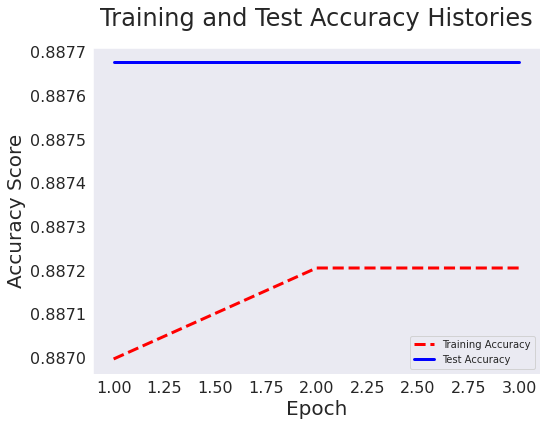

In [39]:
print(history.history.keys())

# Get training and test accuracy histories
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

import matplotlib.pyplot as plt
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
# Visualize accuracy history
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.title("Training and Test Accuracy Histories")
plt.ylabel("Accuracy Score")
plt.show()

History of Loss

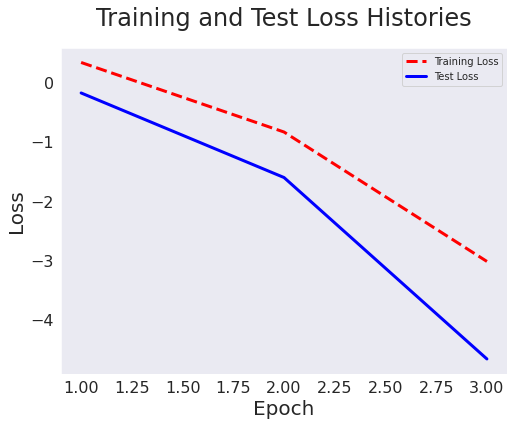

In [40]:
# Get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
# Create count of the number of epochs

import matplotlib.pyplot as plt
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.title("Training and Test Loss Histories")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Evaluate

In [41]:
# Predict the output for our test dataset. 
# If the prediction is greater than 0.5 then the output is 1 else the output is 0
y_pred=classifier.predict(X_test)
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[10969     0]
 [ 1388     0]]


Visualizing Neural Networks

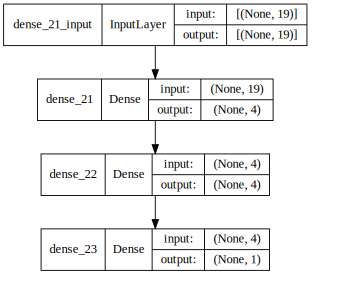

In [44]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot


SVG(model_to_dot(classifier, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))